In [12]:
import glob
import pandas as pd
import numpy as np
import qiime2 as q2
import time
from qiime2.plugins.mmvec.actions import paired_omics                                   
from biom import load_table, Table
from skbio import OrdinationResults

import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

%matplotlib inline

#turn off warnings
import warnings
warnings.filterwarnings("ignore")
#turn off tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


In [2]:
#load the data
omic_keys = [omics_.split('/')[-1].split('.')[0] for omics_ in glob.glob('../data/*.biom')]
tables_shared = {k_: load_table('../data/{}.biom'.format(k_)) for k_ in omic_keys}
metadata_shared = pd.read_csv('../data/sample-metadata-plus-train-tests-case-study.csv', index_col=0)

In [3]:
#change index name to 'sample id'
metadata_shared.index.name = 'sample id'

#change train to Train and test to Test
metadata_shared['train_test_mmvec'] = metadata_shared['train_test'].apply(lambda x: 'Train' if x == 'train' else 'Test')

In [4]:
print(metadata_shared.shape)
metadata_shared.head()

(135, 492)


,Participant ID,site_sub_coll,data_type,week_num,date_of_receipt,interval_days,visit_num,Research Project,PDO Number,GSSR IDs,...,Tube A and B received at Broad:,stool_id,smoking status,Number years smoked,Age when started smoking,How many cigarettes/cigars/etc. do you smoke per day?,Testing,diagnosis_binned,train_test,train_test_mmvec
sample id,,,,,,,,,,,,,,,,,,,,,
MSM9VZFR,M2079,M2079C5,metabolomics,8.0,2015-09-09,15.0,8,ibdmdb,NaN,NaN,...,No,NaN,NaN,NaN,NaN,NaN,Train,nonIBD,train,Train
MSM9VZGO,M2061,M2061C14,metabolomics,30.0,2015-08-12,15.0,19,ibdmdb,NaN,NaN,...,No,NaN,NaN,NaN,NaN,NaN,Train,nonIBD,train,Train
CSM67UEA,C3005,C3005C15,metabolomics,27.0,2014-12-02,14.0,20,ibdmdb,NaN,NaN,...,No,NaN,NaN,NaN,NaN,NaN,Train,IBD,train,Train
HSM7J4HS,H4035,H4035C5,metabolomics,8.0,2015-06-16,14.0,8,ibdmdb,NaN,NaN,...,No,NaN,NaN,NaN,NaN,NaN,Test,IBD,train,Train
CSMAG78W,C3022,C3022C23,metabolomics,46.0,2015-10-15,16.0,29,ibdmdb,NaN,NaN,...,No,NaN,NaN,NaN,NaN,NaN,Test,nonIBD,train,Train


In [5]:
#for tables: virome_virmap_analysis, HMP2_proteomics_ecs, HMP2_metabolomics
#keep only features that appear in at least 10 samples
#tables_shared['virome_virmap_analysis'] = tables_shared['virome_virmap_analysis'].filter(lambda val, id_, md: val.sum() > 10, axis='observation')
#tables_shared['HMP2_proteomics_ecs'] = tables_shared['HMP2_proteomics_ecs'].filter(lambda val, id_, md: val.sum() > 10, axis='observation')
#tables_shared['HMP2_metabolomics'] = tables_shared['HMP2_metabolomics'].filter(lambda val, id_, md: val.sum() > 10, axis='observation')

In [5]:
title_bls = {'HMP2_metabolomics':'Metabolomics',
             'shared_meta_g_taxonomic_profiles':'MetaG\n(taxonomy)',
             'virome_virmap_analysis':'Virome',
             'HMP2_proteomics_ecs':'Proteomics',
             'meta_t_ecs':'MetaT\n(pathway)'}

In [6]:
# ref: https://github.com/biocore/mmvec/blob/88ca33b408a85b6bf90fae06982936247b860272/mmvec/q2/_method.py#L14
runtime = {}
CV_summaries = {}
results = {}
ranks = {}

#assuming we have the following omics:
pairs = [('HMP2_proteomics_ecs', 'HMP2_proteomics_ecs'),
         ('HMP2_proteomics_ecs', 'shared_meta_g_taxonomic_profiles'),
         ('shared_meta_g_taxonomic_profiles', 'HMP2_proteomics_ecs'),
         ('shared_meta_g_taxonomic_profiles', 'shared_meta_g_taxonomic_profiles'),
         ('HMP2_proteomics_ecs', 'virome_virmap_analysis'),
         ('virome_virmap_analysis', 'HMP2_proteomics_ecs'),
         ('virome_virmap_analysis', 'virome_virmap_analysis'),
         ('HMP2_proteomics_ecs', 'meta_t_ecs'),
         ('meta_t_ecs', 'HMP2_proteomics_ecs'),
         ('meta_t_ecs', 'meta_t_ecs'),
         ('virome_virmap_analysis', 'shared_meta_g_taxonomic_profiles'), 
         ('shared_meta_g_taxonomic_profiles', 'virome_virmap_analysis'), 
         ('virome_virmap_analysis', 'meta_t_ecs'),
         ('meta_t_ecs', 'virome_virmap_analysis'),
         ('shared_meta_g_taxonomic_profiles', 'meta_t_ecs'),
         ('meta_t_ecs', 'shared_meta_g_taxonomic_profiles')]

for pair in pairs:
    print(pair)
    #get tables and set to correct format
    t1 = tables_shared[pair[0]]
    t2 = tables_shared[pair[1]]
    t1_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', t1)
    t2_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', t2)
    
    #run and time mmvec
    time_start = time.perf_counter()
    mmvec_res = paired_omics(t1_q2, t2_q2, 
                             summary_interval=1,
                             metadata=q2.Metadata(metadata_shared),
                             training_column='train_test_mmvec',
                             min_feature_count=10)
    time_elapsed = (time.perf_counter() - time_start)
    print('Time elapsed: ', round(time_elapsed,4))
    
    #save output
    runtime["{}-{}".format(pair[0], pair[1])] = time_elapsed
    CV_summaries["{}-{}".format(pair[0], pair[1])] = mmvec_res.model_stats.view(q2.Metadata).to_dataframe()
    results["{}-{}".format(pair[0], pair[1])] = mmvec_res
    ranks["{}-{}".format(pair[0], pair[1])] = mmvec_res.conditionals.view(pd.DataFrame)

('HMP2_proteomics_ecs', 'shared_meta_g_taxonomic_profiles')


Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




100%|██████████| 22294/22294 [00:16<00:00, 1348.32it/s]


Time elapsed:  21.0474
('HMP2_proteomics_ecs', 'virome_virmap_analysis')


100%|██████████| 22294/22294 [00:16<00:00, 1336.14it/s]


Time elapsed:  21.1966
('HMP2_proteomics_ecs', 'meta_t_ecs')


100%|██████████| 22294/22294 [01:53<00:00, 196.97it/s]


Time elapsed:  135.846
('virome_virmap_analysis', 'shared_meta_g_taxonomic_profiles')


100%|██████████| 446/446 [00:00<00:00, 766.33it/s]


Time elapsed:  3.2926
('virome_virmap_analysis', 'meta_t_ecs')


100%|██████████| 446/446 [00:02<00:00, 186.12it/s]


Time elapsed:  20.153


In [7]:
results

{'HMP2_proteomics_ecs-shared_meta_g_taxonomic_profiles': Results (name = value)
 --------------------------------------------------------------------------------------------------------------
 conditionals       = <artifact: FeatureData[Conditional] uuid: a7299bcc-0099-48ee-bbd4-323c35130e16>
 conditional_biplot = <artifact: PCoAResults % Properties('biplot') uuid: 5a4828b2-df05-479e-b24a-dc3e91667bec>
 model_stats        = <artifact: SampleData[MMvecStats] uuid: 73b032ea-cd2f-42f6-bb74-1409ae7a59ee>,
 'HMP2_proteomics_ecs-virome_virmap_analysis': Results (name = value)
 --------------------------------------------------------------------------------------------------------------
 conditionals       = <artifact: FeatureData[Conditional] uuid: bca1ba72-9db8-4e4f-9d3c-98029c8bb8e0>
 conditional_biplot = <artifact: PCoAResults % Properties('biplot') uuid: 57ec63fa-3ab2-438b-afad-d8a072a4b987>
 model_stats        = <artifact: SampleData[MMvecStats] uuid: c0b9dc93-72ea-442c-9b73-44f346edca1

In [8]:
#save mmvec results as json/pickle
with open("../results/mmvec-runtime.json", "w") as outfile: 
   json.dump(runtime, outfile)

with open("../results/mmvec-ranks.pickle", 'wb') as outfile:
    pickle.dump(ranks, outfile)

with open("../results/mmvec-results.pickle", 'wb') as outfile:
    pickle.dump(results, outfile)

('HMP2_proteomics_ecs', 'shared_meta_g_taxonomic_profiles')


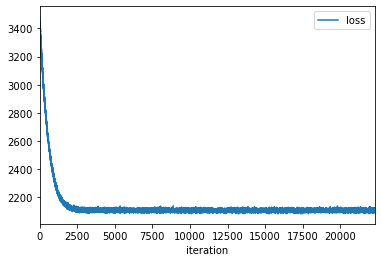

('HMP2_proteomics_ecs', 'virome_virmap_analysis')


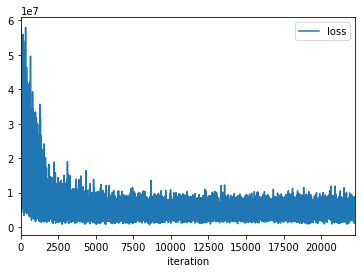

('HMP2_proteomics_ecs', 'meta_t_ecs')


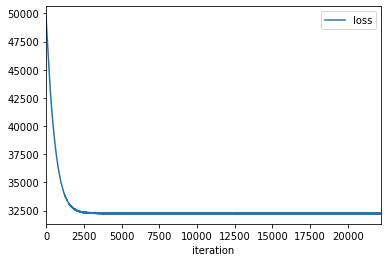

('virome_virmap_analysis', 'shared_meta_g_taxonomic_profiles')


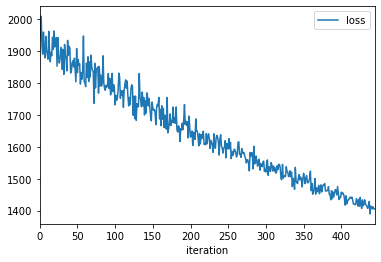

('virome_virmap_analysis', 'meta_t_ecs')


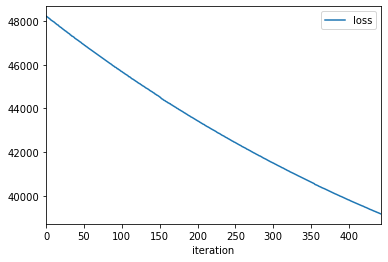

In [9]:
#plot loss for each iteration
for pair in pairs:
    print(pair)
    CV_summaries["{}-{}".format(pair[0], pair[1])].plot(x='iteration', y='loss', label='loss')
    plt.show()

### Run-time comparison

In [10]:
#load joint-rpca runtime
joint_rpca_runtime = pd.read_csv('../results/joint-rpca-runtime.csv')
#change col names
joint_rpca_runtime.columns = ['method', 'time (s)']
#change ('Joint-RPCA', 5) to joint-rpca
joint_rpca_runtime.method = 'joint-rpca'
joint_rpca_runtime

#load mmvec runtime
with open('../results/mmvec-runtime.json') as f:
    mmvec_runtime = json.load(f)
mmvec_runtime_df = pd.DataFrame(mmvec_runtime.items(), columns=['method', 'time (s)'])
mmvec_runtime_df

##append mmvec runtime to joint-rpca runtime
runtime_df = joint_rpca_runtime.append(mmvec_runtime_df)

In [13]:
#load joint-rpca ord
joint_rpca_ord = OrdinationResults.read('../results/joint-rpca-ord.txt')

In [17]:
#create df with # of features for each pair
n_features_df = pd.DataFrame(columns=['method', 'N_features'])
for pair in ranks.keys():
    n_ = ranks[pair].shape[0] + ranks[pair].shape[1]
    n_features_df = n_features_df.append({'method': pair, 
                                          'N_features': n_}, 
                                          ignore_index=True)
    
n_features_df = n_features_df.append({'method': 'joint-rpca',
                                      'N_features': joint_rpca_ord.features.shape[0]}, 
                                      ignore_index=True)

#append runtime to n_features_df
n_features_df = pd.concat([n_features_df.set_index('method'), runtime_df.set_index('method')], axis=1)
n_features_df

,N_features,time (s)
HMP2_proteomics_ecs-meta_t_ecs,8591,135.846005
HMP2_proteomics_ecs-shared_meta_g_taxonomic_profiles,481,21.047448
HMP2_proteomics_ecs-virome_virmap_analysis,560,21.196570
joint-rpca,87343,20.862690
virome_virmap_analysis-meta_t_ecs,8299,20.153024
virome_virmap_analysis-shared_meta_g_taxonomic_profiles,189,3.292594


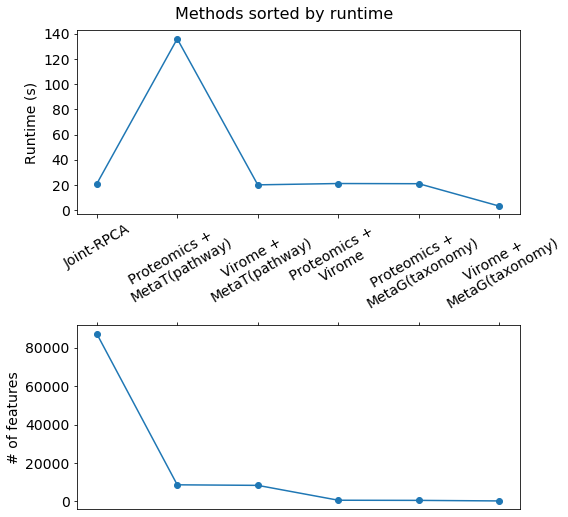

In [39]:
order = n_features_df.sort_values('N_features', ascending=False).index

nicer_labels = {'HMP2_proteomics_ecs-shared_meta_g_taxonomic_profiles': 'Proteomics + \nMetaG(taxonomy)',
                'HMP2_proteomics_ecs-virome_virmap_analysis': 'Proteomics + \nVirome',
                'HMP2_proteomics_ecs-meta_t_ecs': 'Proteomics + \nMetaT(pathway)',
                'virome_virmap_analysis-shared_meta_g_taxonomic_profiles': 'Virome + \nMetaG(taxonomy)',
                'virome_virmap_analysis-meta_t_ecs': 'Virome + \nMetaT(pathway)',
                'joint-rpca': 'Joint-RPCA'}

fig, axn = plt.subplots(2, 1, figsize=(8, 7)) #gridspec_kw={'height_ratios': [1,1]})

#now, plot runtimes as lines
n_features_df = n_features_df.loc[order]
axn[0].plot(n_features_df.index, n_features_df['time (s)'], marker='o')
axn[0].set_ylabel('Runtime (s)', fontsize=14)
axn[0].set_xlabel('')
#get nice labels
axn[0].set_xticklabels([nicer_labels[x] for x in order], rotation=30)

#now, plot # of features
axn[1].plot(n_features_df.index, n_features_df['N_features'], marker='o')
axn[1].set_ylabel('# of features', fontsize=14)
axn[1].set_xlabel('')
#hide x-axix labels
axn[1].set_xticklabels([])
#remove bottom ticks and add top ticks
axn[1].tick_params(axis='x', which='both', bottom=False, top=True)

#increase font size
for ax in axn:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

#add title
fig.suptitle('Methods sorted by runtime',
             fontsize=16, x=0.5, y=1.02)
plt.tight_layout()
plt.savefig('../figures/runtime-features-comparison.png', dpi=300)
plt.show()

In [65]:
# # run MMvec (default)
# pairs = [('HMP2_metabolomics', 'virome_virmap_analysis'),
#          ('HMP2_metabolomics', 'shared_meta_g_taxonomic_profiles'),
#          ('HMP2_metabolomics', 'meta_t_ecs')]

# for pair in pairs:
#     print(pair)
#     t1 = tables_shared[pair[0]]
#     t2 = tables_shared[pair[1]]
#     t1_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', t1)
#     t2_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', t2)
#     time_start = time.perf_counter()
#     mmvec_res = paired_omics(t1_q2, t2_q2, 
#                              summary_interval=1,
#                              metadata=q2.Metadata(metadata_shared),
#                              training_column='train_test_mmvec')
#     time_elapsed = (time.perf_counter() - time_start)
#     print('Time elapsed: ', round(time_elapsed,4))
#     runtime[(pair[0], pair[1])] = [time_elapsed]
#     CV_summaries[(pair[0], pair[1])] = mmvec_res.model_stats.view(q2.Metadata).to_dataframe()